# Mapserver - Meteorological Images - Leaflet

In [1]:
from IPython.display import display, HTML
from matplotlib import pyplot as plt
# local
# python setup.py develop
from AlertaDengue.settings import MAPSERVER_URL

import fiona
import geopandas as gpd
import os
# local
# python setup.py develop
import AlertaDengue as alert_dengue

## Setting variables

In [2]:
shp_path = '%s/static/shapefile' % os.path.dirname(alert_dengue.__path__[0])
raster_dir_path = os.path.join(
    os.path.dirname(alert_dengue.__path__[0]),
    'tiffs'
)

local_mapfile_dir = '%s/mapfiles/%%s' % (
    os.path.dirname(alert_dengue.__path__[0])
)

# mapserver variables
ms_shp_path = '/tiffs/'
ms_error_path = '/var/log/mapserver.log'
ms_cgi_path = MAPSERVER_URL + '?map=%s&'
ms_mapfile_name = '%s.map'
ms_mapfile_dir = '/maps/%s'

In [3]:
# Rio de Janeiro's conf
geocode = 3304557
city_name = 'Rio de Janeiro'
alert_level = 2
disease = 'dengue'

## Check Shapefile

/media/xmn/29bd0df7-9ccb-4dd1-93a0-e47e2b4f2fc2/dev/fgv_fiocruz/AlertaDengue/AlertaDengue/static/shapefile/3304557.shp


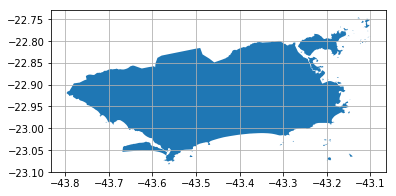

In [4]:
shapefile_path = os.path.join(shp_path, '%s.shp' % geocode)
print(shapefile_path)
gdf = gpd.GeoDataFrame.from_file(shapefile_path)
gdf.plot()

plt.grid(True)
plt.show()

In [5]:
# boundaries
gdf.bounds

,minx,miny,maxx,maxy
0,-43.796539,-23.082893,-43.099039,-22.74602


In [6]:
bounds = gdf.bounds.iloc[0].values
str_boundaries = [str(v) for v in bounds]
extent = ' '.join(str_boundaries)
extent_url = ','.join(str_boundaries)

In [7]:
# crs/srs
gdf.crs

{'init': 'epsg:4326'}

In [8]:
crs_proj = gdf.crs['init']
wms_srs = crs_proj.upper()

## Visualize raster images

In [9]:
# raster_layer_bounds
# BoundingBox(
#  left=-74.02117941144857, 
#  bottom=-33.776654682894005, 
#  right=-34.76480149542548, 
#  top=5.300060176305177)
# leaflet bounds ex: [[40.712216, -74.22655], [40.773941, -74.12544]];
raster_layer_bounds = [[bounds[0], bounds[1]], [bounds[2], bounds[3]]]
raster_layer_bounds

[[-43.79653853090349, -23.0828926973403],
 [-43.09903940038369, -22.746020285810395]]

## Visualizing the map

In [10]:
HTML('''
<script type="text/javascript">
    var extent_url = '%s';
    var crs_proj = '%s';
    var raster_layer_bounds = %s;
    var mapserverURL = '%s';
</script>
''' % (extent_url, crs_proj, raster_layer_bounds, MAPSERVER_URL))

In [22]:
%%html

<style>

.legend {
    line-height: 18px;
    color: #555;
}

.legend i {
    width: 18px;
    height: 18px;
    float: left;
    margin-right: 8px;
    opacity: 0.7;
}

</style>

<div id="alerta_dengue" style="height: 400px; width: 800px;"></div>

<link rel="stylesheet" href="lib/leaflet/leaflet.css" />
<script type="text/javascript" src="lib/leaflet/leaflet.js"></script>

<script>

var url_crs_proj = crs_proj.toUpperCase() == 'EPSG:4326' ? 'CRS:84' : crs_proj;

var mapfile_url = (
    mapserverURL + '?map=/maps/alert/dengue.map&' + 
    'SERVICE=WMS&VERSION=1.3.0&REQUEST=GetMap&LAYERS=RIO_DE_JANEIRO&' +
    'STYLES=&CRS=CRS:84&BBOX=' + extent_url + '&' +
    'WIDTH=800&HEIGHT=400&FORMAT=image/png'
);
console.log(mapfile_url);

var mapfile_raster_url = (
    mapserverURL + '?map=/maps/meteorological/%(map_name)s.map&' + 
    'SERVICE=WMS&VERSION=1.3.0&REQUEST=GetMap&LAYERS=RIO_DE_JANEIRO&' +
    'STYLES=&CRS=CRS:84&BBOX=' + extent_url + '&' +
    'WIDTH=800&HEIGHT=400&FORMAT=image/png'
);
console.log(mapfile_raster_url);

var osmUrl='http://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png';
var osmAttrib = 'Map data © <a href="http://openstreetmap.org">OpenStreetMap</a> contributors';

var raster_url = '';
var raster_layer;
var geocode = '3304557';

var minZoom = 9;
var maxZoom = 11;
var zoom = 10;

//# openstreetmap
var osm = L.tileLayer(osmUrl, {
    attribution: osmAttrib,
    crs: L.CRS.EPSG4326,
    minZoom: minZoom,
    maxZoom: maxZoom
});

var baseMap = {"OSM": osm};

var map = L.map(
    'alerta_dengue', {
        //crs: L.CRS.EPSG4326,
        center: new L.LatLng(-22.9192,-43.4441),
        zoom: zoom,
        layers: [osm]
    }
); 

//# mapserver shapefile
var ms_shapefile = L.tileLayer.wms(mapfile_url, {
    layers: 'RIO_DE_JANEIRO',
    format: 'image/png',
    transparent: true,
    attribution: "Info Dengue",
    srs:"EPSG:4326",
    crs: L.CRS.EPSG4326,
    minZoom: minZoom,
    maxZoom: maxZoom,
});

//# mapserver raster
var raster_conf = {
    layers: 'RIO_DE_JANEIRO',
    format: 'image/png',
    transparent: true,
    attribution: "Info Dengue",
    srs:"EPSG:4326",
    crs: L.CRS.EPSG4326,
    minZoom: minZoom,
    maxZoom: maxZoom,
};

var ms_rasters = {
    'NDVI': null,
    'LST_Day_1km': null,
    'LST_Night_1km': null,
    'relative_humidity_2m_above_ground': null,
    'specific_humidity_2m_above_ground': null,
    'Precipitation': null
}

var raster_name;
var overlayMaps = {
    'Rio de Janeiro': ms_shapefile,
};

var url = '';
for (raster_name in ms_rasters){
    url = mapfile_raster_url.replace('%(map_name)s', raster_name.toLowerCase());
    console.log(url);
    ms_rasters[raster_name] = L.tileLayer.wms(url, raster_conf);
    overlayMaps[raster_name] = ms_rasters[raster_name];
}

ms_shapefile.addTo(map);

// L.control.layers(baseMap, overlayMaps).addTo(map);

var legend = L.control({position: 'bottomright'});

legend.onAdd = function (map) {
    var div = L.DomUtil.create('div', 'info legend');

    div.innerHTML += (
        '<table>' +
        '  <tr>' +
        '    <td style="vertical-align:top;">máx.</td>' + 
        '    <td rowspan="2"><img src="img/symbols/colorbar.png" /></td>' +
        '  </tr>' + 
        '  <tr>' + 
        '    <td style="vertical-align:bottom;background-color:#ffffff!important;">mín.</td>' +
        '  </tr>' + 
        '</table>'
    );

    return div;
};

legend.addTo(map);

var layer_control = L.control({position: 'topright'});

layer_control.onAdd = function (map) {
    var div = L.DomUtil.create('div', 'info legend');
    var radio_template = (
        '<input type="radio" name="switch_layer" ' +
        '       onclick="switchLayer(\'layer_name\')" /> layer_name <br/>'
    );
    
    var content = '';
    content += (
        '<div style="background-color:#ffffff!important;' +
        'padding:10px;border:#CCCCCC solid 1px;' +
        'font-size:10px;' +
        '">'
    );
    for (raster_name in ms_rasters){
        content += radio_template.replace(/layer_name/g, raster_name);
    }
    content += '</div>';
    div.innerHTML += content;

    return div;
};

layer_control.addTo(map);

function switchLayer(layer_name) {
    for (raster_name in ms_rasters){
        map.removeLayer(ms_rasters[raster_name]);
    }
    
    ms_rasters[layer_name].addTo(map);
}

</script>